In [537]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

url = "~/documents/python/ruter_data_2.csv"
df = pd.read_csv(url, sep=';')


In [538]:
#Konverteringen roter til datoene.
#Skiller ut Trip_ID og Date som egen feature (samme buss med samme stoppesteder)
df["Trip_Id"] = df.TurId.apply(lambda x: re.search('([0-9]+)\-', x).group(1)) 
df["Date"] = df.TurId.apply(lambda x: re.search('-([0-9,-z]+)T', x).group(1))
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord,Trip_Id,Date
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5,15006,2020-08-10
1,15002-2020-08-15T12:54:00+02:00,15/08/2020,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5,15002,2020-08-15
2,15004-2020-08-03T09:54:00+02:00,03/08/2020,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6,15004,2020-08-03
3,15003-2020-07-27T13:00:00+02:00,27/07/2020,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10,15003,2020-07-27
4,15002-2020-08-27T07:15:00+02:00,27/08/2020,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10,15002,2020-08-27


In [539]:
#Vil også ha en kolonne som viser ukedager
df['Ukedag'] = df['Date'].dt.day_name()

In [540]:
#Noen verdier i kolonnen Passasjerer_Ombord er negative. 
#Antar dette er feil. Korrigerer disse til 0:
for index, row in df.iterrows():
    if df.loc[index, 'Passasjerer_Ombord'] < 0:
        df.loc[index,'Passasjerer_Ombord'] = 0

In [541]:
df['Trip_Id'] = df['Trip_Id'].astype(str).astype(int)
df_1=df
df_1 = df_1.drop(df_1[df_1.Trip_Id != 44003].index)
df_1 = df_1.drop(df_1[df_1.Linjeretning < 1].index)
#Vi har nå en buss fra et stopp til et annet, en retning
#df_1 = Kun turer med TripId 44003

<AxesSubplot:xlabel='Ukedag', ylabel='Passasjerer_Ombord'>

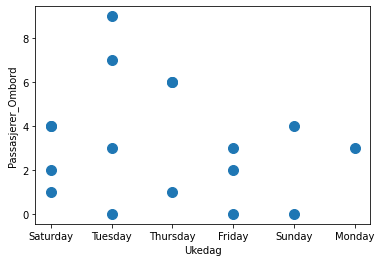

In [542]:
df_1.plot.scatter(x='Ukedag', y='Passasjerer_Ombord', s=100)

<AxesSubplot:xlabel='Ukedag', ylabel='Passasjerer_Ombord'>

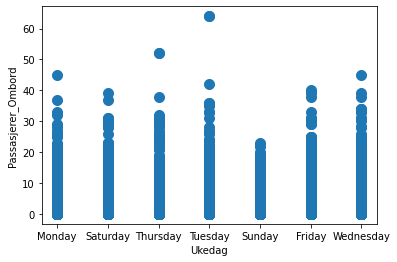

In [543]:
#Tilsvarende plot for hele datasettet
df.plot.scatter(x='Ukedag', y='Passasjerer_Ombord', s=100)

<AxesSubplot:xlabel='Ukedag', ylabel='Passasjerer_Ombord'>

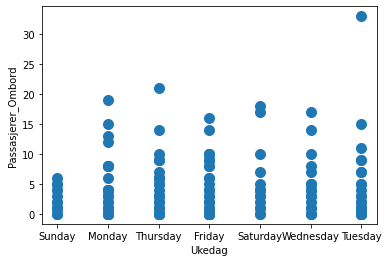

In [544]:
#Ser på et spesifikt linjenavn, i stedet for Trip_Id.
df_2 = df.drop(df[df.Linjenavn != "440"].index)
df_2.plot.scatter(x='Ukedag', y='Passasjerer_Ombord', s=100)
#Tilsvarende plot for busser med linjenavn 440:

<AxesSubplot:xlabel='Date', ylabel='Passasjerer_Ombord'>

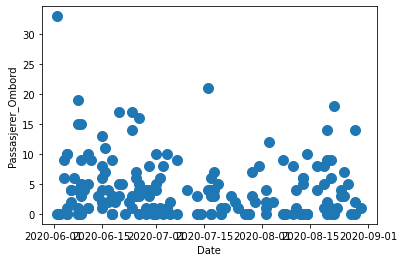

In [545]:
#Lager ny kolonne der datoer er rangert etter dager fra 010101.
#Slik at jeg kan lage en prediksjon.
df_2['Date_2']=df['Date'].map(datetime.datetime.toordinal)
df_2.plot.scatter(x='Date', y='Passasjerer_Ombord', s=100)
#Scatterplot, linjenavn 440, med dato istedetfor ukedag:

In [546]:
#Lager noen nye features
df_2['Måned'] = [i.month for i in df_2['Date']]
df_2['År'] = [i.year for i in df_2['Date']]
df_2['Dag'] = [i.day for i in df_2['Date']]
#Skiller ut nye feature i eget datasett:
data = df_2[['Trip_Id', 'Passasjerer_Ombord', 'Date', 'Date_2', 'Måned', 'Dag', 'Ukedag']] 
data.head()

,Trip_Id,Passasjerer_Ombord,Date,Date_2,Måned,Dag,Ukedag
96,44002,1,2020-06-28,737604,6,28,Sunday
98,44003,2,2020-06-15,737591,6,15,Monday
99,44003,0,2020-08-10,737647,8,10,Monday
102,44003,6,2020-06-04,737580,6,4,Thursday
104,44002,0,2020-06-22,737598,6,22,Monday


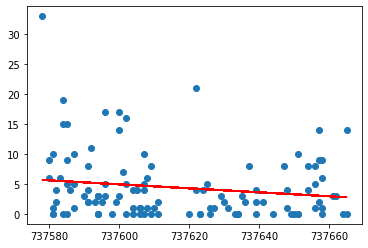

MSE = 29.162974666793577


In [547]:
#Bruker linjenummer 440 til å se om jeg finner noen plausible prediksjoner
X = pd.DataFrame(data['Date_2']) 
y = pd.DataFrame(data['Passasjerer_Ombord'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
linear_regressor = LinearRegression()  
linear_regressor.fit(X_train, y_train) 
Y_pred = linear_regressor.predict(X_train) 
plt.scatter(X_train, y_train)             
plt.plot(X_train, Y_pred, color='red')    
plt.show()                                
print( "MSE = "+str(metrics.mean_squared_error(y_train,Y_pred))) 

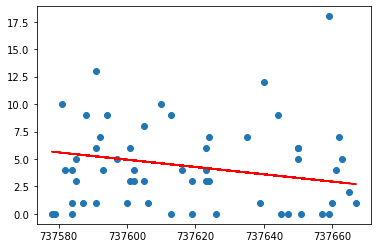

MSE = 15.64503209573306


In [548]:
#Sjekker hvordan det fungerer på test-settet:
Y_pred = linear_regressor.predict(X_test)  
plt.scatter(X_test, y_test)
plt.plot(X_test, Y_pred, color='red')
plt.show()
print( "MSE = "+str(metrics.mean_squared_error(y_test,Y_pred)))

In [549]:
#Sjekker på en konkret dato
linear_regressor.predict([[737630]])

array([[3.94120733]])